# Stroke Classfier
> - Gabrile Serafini
> - Marco Sousa-Poza

This Notebook discribes the computations made to find an optimal stroke classifier based on real healthcare data.

## Exploring the Data
In the following the data will be read and prepared for further use.

In [2]:
# All the necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [53]:
# Reading the data into a data frame
df_health = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df_health.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


We see that the data contains some NaN values. If there are not too many we can delete them.

In [4]:
print("The number of NaN values for each column is:")
print(df_health.isna().sum())
print("There are {} rows in this df.".format(df_health.shape[0]))

The number of NaN values for each column is:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
There are 5110 rows in this df.


Next we change the nominal attributes to numbers. This is important for the more mathematical models we are going to use later on.

In [7]:
for col in df_health.select_dtypes(include=['object']).columns:
    print(df_health[col].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
Yes    3353
No     1757
Name: ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


## Clean Data

Next we change the nominal attributes to numerical ones. This is important for the numerical classifiers.

In [54]:
# We again find some hidden NaN values. We can delete those:
df_health.drop(df_health[df_health['gender'] == 'Other'].index, inplace=True)

gender_dict = {'Female':1, 'Male':0}
married_dict = {'Yes':1, 'No':0}
worktype_dict = {'Private':4, 'Self-employed':3, 'children':2, 'Govt_job':1, 'Never_worked':0}
residence_dict = {'Urban':1, 'Rural':0}
smoke_dict = {'never smoked':0,'formerly smoked':1,'smokes':1, 'Unknown':-1}
health_numerical = df_health.replace(
    {
        'gender':gender_dict,
        'ever_married':married_dict,
        'work_type':worktype_dict,
        'Residence_type':residence_dict,
        'smoking_status':smoke_dict
    }
)

We saw earlier that there are some many `Nan` values in the bmi column. Therefore we will atempt to mean those values based on the gender and the age group.

In [55]:
df_mean = df_health.groupby(['gender', pd.cut(df_health['age'], np.arange(0, 100, 10))]).mean()
df_mean.index = df_mean.index.set_names(['gender', 'age_group'])
df_mean = df_mean.drop(['id', 'hypertension', 'age', 'heart_disease', 'stroke', 'avg_glucose_level'], axis=1)

df_health['age_group'] = pd.cut(df_health['age'], np.arange(0, 100, 10))
df_health = df_health.set_index(['gender', 'age_group'])

df_health[df_health['bmi'] == np.nan]
df_health['bmi'].fillna(df_mean['bmi'], inplace=True)
df_health.reset_index(drop='age_group', inplace=True)
print(df_health['bmi'].isna().sum())

0


In [ ]:
health_np = health_numerical.values

Let also standardize the data to get rid of any scalars

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

y = df_health['stroke'].values
columns = list(df_health.columns[:-1])
target = df_health.columns[-1]
X_n = health_numerical[:, :-1]
X_normal = sc.fit_transform(X_n)
X_v = df_health.values[:, :-1]

## Infer Data
We notice that quite some people do not have a smoking status. Maybe we can try to classify them. For that to work we need to get rid of the hart-attack columns. Otherwise we get the situation where the hart-attack predictor has circular reasoning.

In [ ]:
df_smoke = df_health[df_health['smoking_status'] != 'Unknown'].drop('stroke')
df_unknown = df_health[df_health['smoking_status'] != 'Unknown'].drop('stroke')

## Data Vizualisation



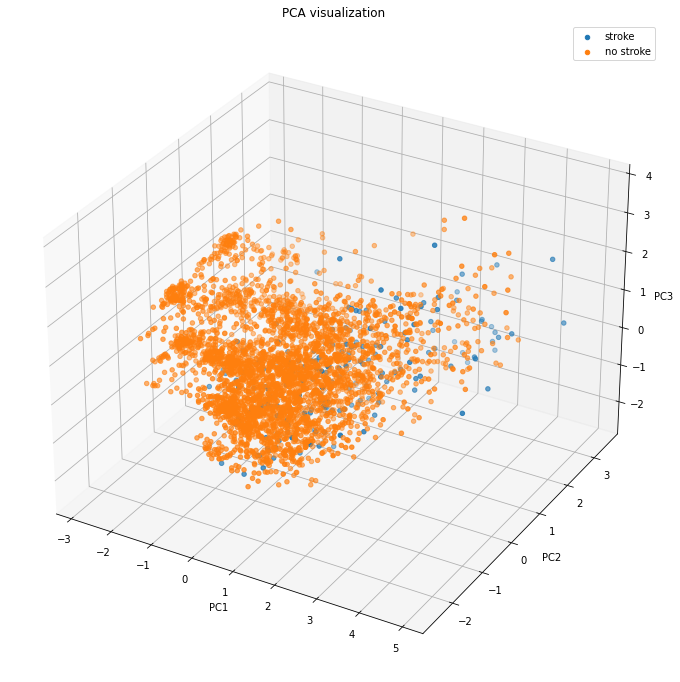

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
stc = StandardScaler()
pca = PCA()
p = Pipeline([('scaler', stc), ('pca', pca)])
health_pca = p.fit_transform(X_n)

# Plot PCA
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(health_pca[y==1][:,0], health_pca[y==1][:,1], health_pca[y==1][:,2], label='stroke')
ax.scatter(health_pca[y==0][:,0], health_pca[y==0][:,1], health_pca[y==0][:,2], label='no stroke')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
ax.set_title('PCA visualization')

plt.show()

We can see that the data is not well separated by the PCs. This is a indicator that the data will probably not be that well separated with a linear model. This is something we need to keep in mind when choosing hyperparameters for some of our classifiers.

#### Correlations
Let us see if there are any correlations

Text(0.5, 1.0, 'Correlation Matrix')

<Figure size 1440x1440 with 0 Axes>

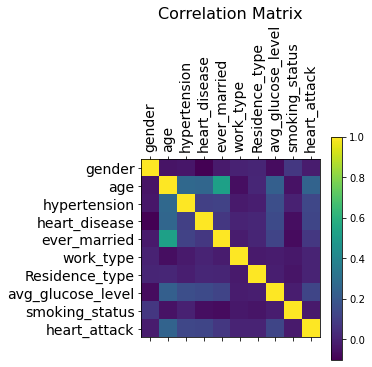

In [40]:
from pandas import DataFrame

fig = plt.figure(figsize=(20, 20))
plt.matshow(DataFrame(health_numerical).corr())
plt.xticks(np.arange(len(columns)+1), columns+['heart_attack'], fontsize=14, rotation=90)
plt.yticks(np.arange(len(columns)+1), columns+['heart_attack'], fontsize=14)
cb = plt.colorbar()
plt.title('Correlation Matrix', fontsize=16)


## Classification
### Random Forest

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from itertools import product

min_splits = [n for n in range(2, 60, 2)]
max_depth = [n for n in range(10,120,5)]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20)

avg_scores = []
for h1, h2 in product(min_splits, max_depth):
    model = DecisionTreeClassifier(
        criterion='gini', 
        max_depth=h2, 
        min_samples_split=h1
    )
    scores = cross_val_score(model, X_normal, y, scoring='recall', cv=cv, n_jobs=-1)
    avg_scores.append(((h1, h2), np.mean(scores)))

avg_scores = sorted(avg_scores, key=lambda x: x[1], reverse=True)
print('The 10 best hyper-parameters are:')
for i in range(10):
    param, score = avg_scores[i] 
    print('-{} place: parameters: splits={} and depth={}, recall={}'.format(i+1, *param, score))

The 10 best hyper-parameters are:
-1 place: parameters: splits=2 and depth=80, recall=0.1729939024390244
-2 place: parameters: splits=2 and depth=40, recall=0.17080487804878047
-3 place: parameters: splits=2 and depth=30, recall=0.1687621951219512
-4 place: parameters: splits=2 and depth=75, recall=0.16709756097560977
-5 place: parameters: splits=2 and depth=70, recall=0.16590243902439025
-6 place: parameters: splits=2 and depth=45, recall=0.16561585365853657
-7 place: parameters: splits=2 and depth=55, recall=0.16457317073170727
-8 place: parameters: splits=2 and depth=105, recall=0.1641280487804878
-9 place: parameters: splits=2 and depth=95, recall=0.16409756097560976
-10 place: parameters: splits=2 and depth=50, recall=0.1636463414634146


In [ ]:
from sklearn.tree import plot_tree
import seaborn as sns

clf = DecisionTreeClassifier(criterion='entropy', max_depth=70, min_samples_split=2)
clf.fit(X_n, y)

DecisionTreeClassifier(criterion='entropy', max_depth=70)

Vizualize the tree to gain some imformation:

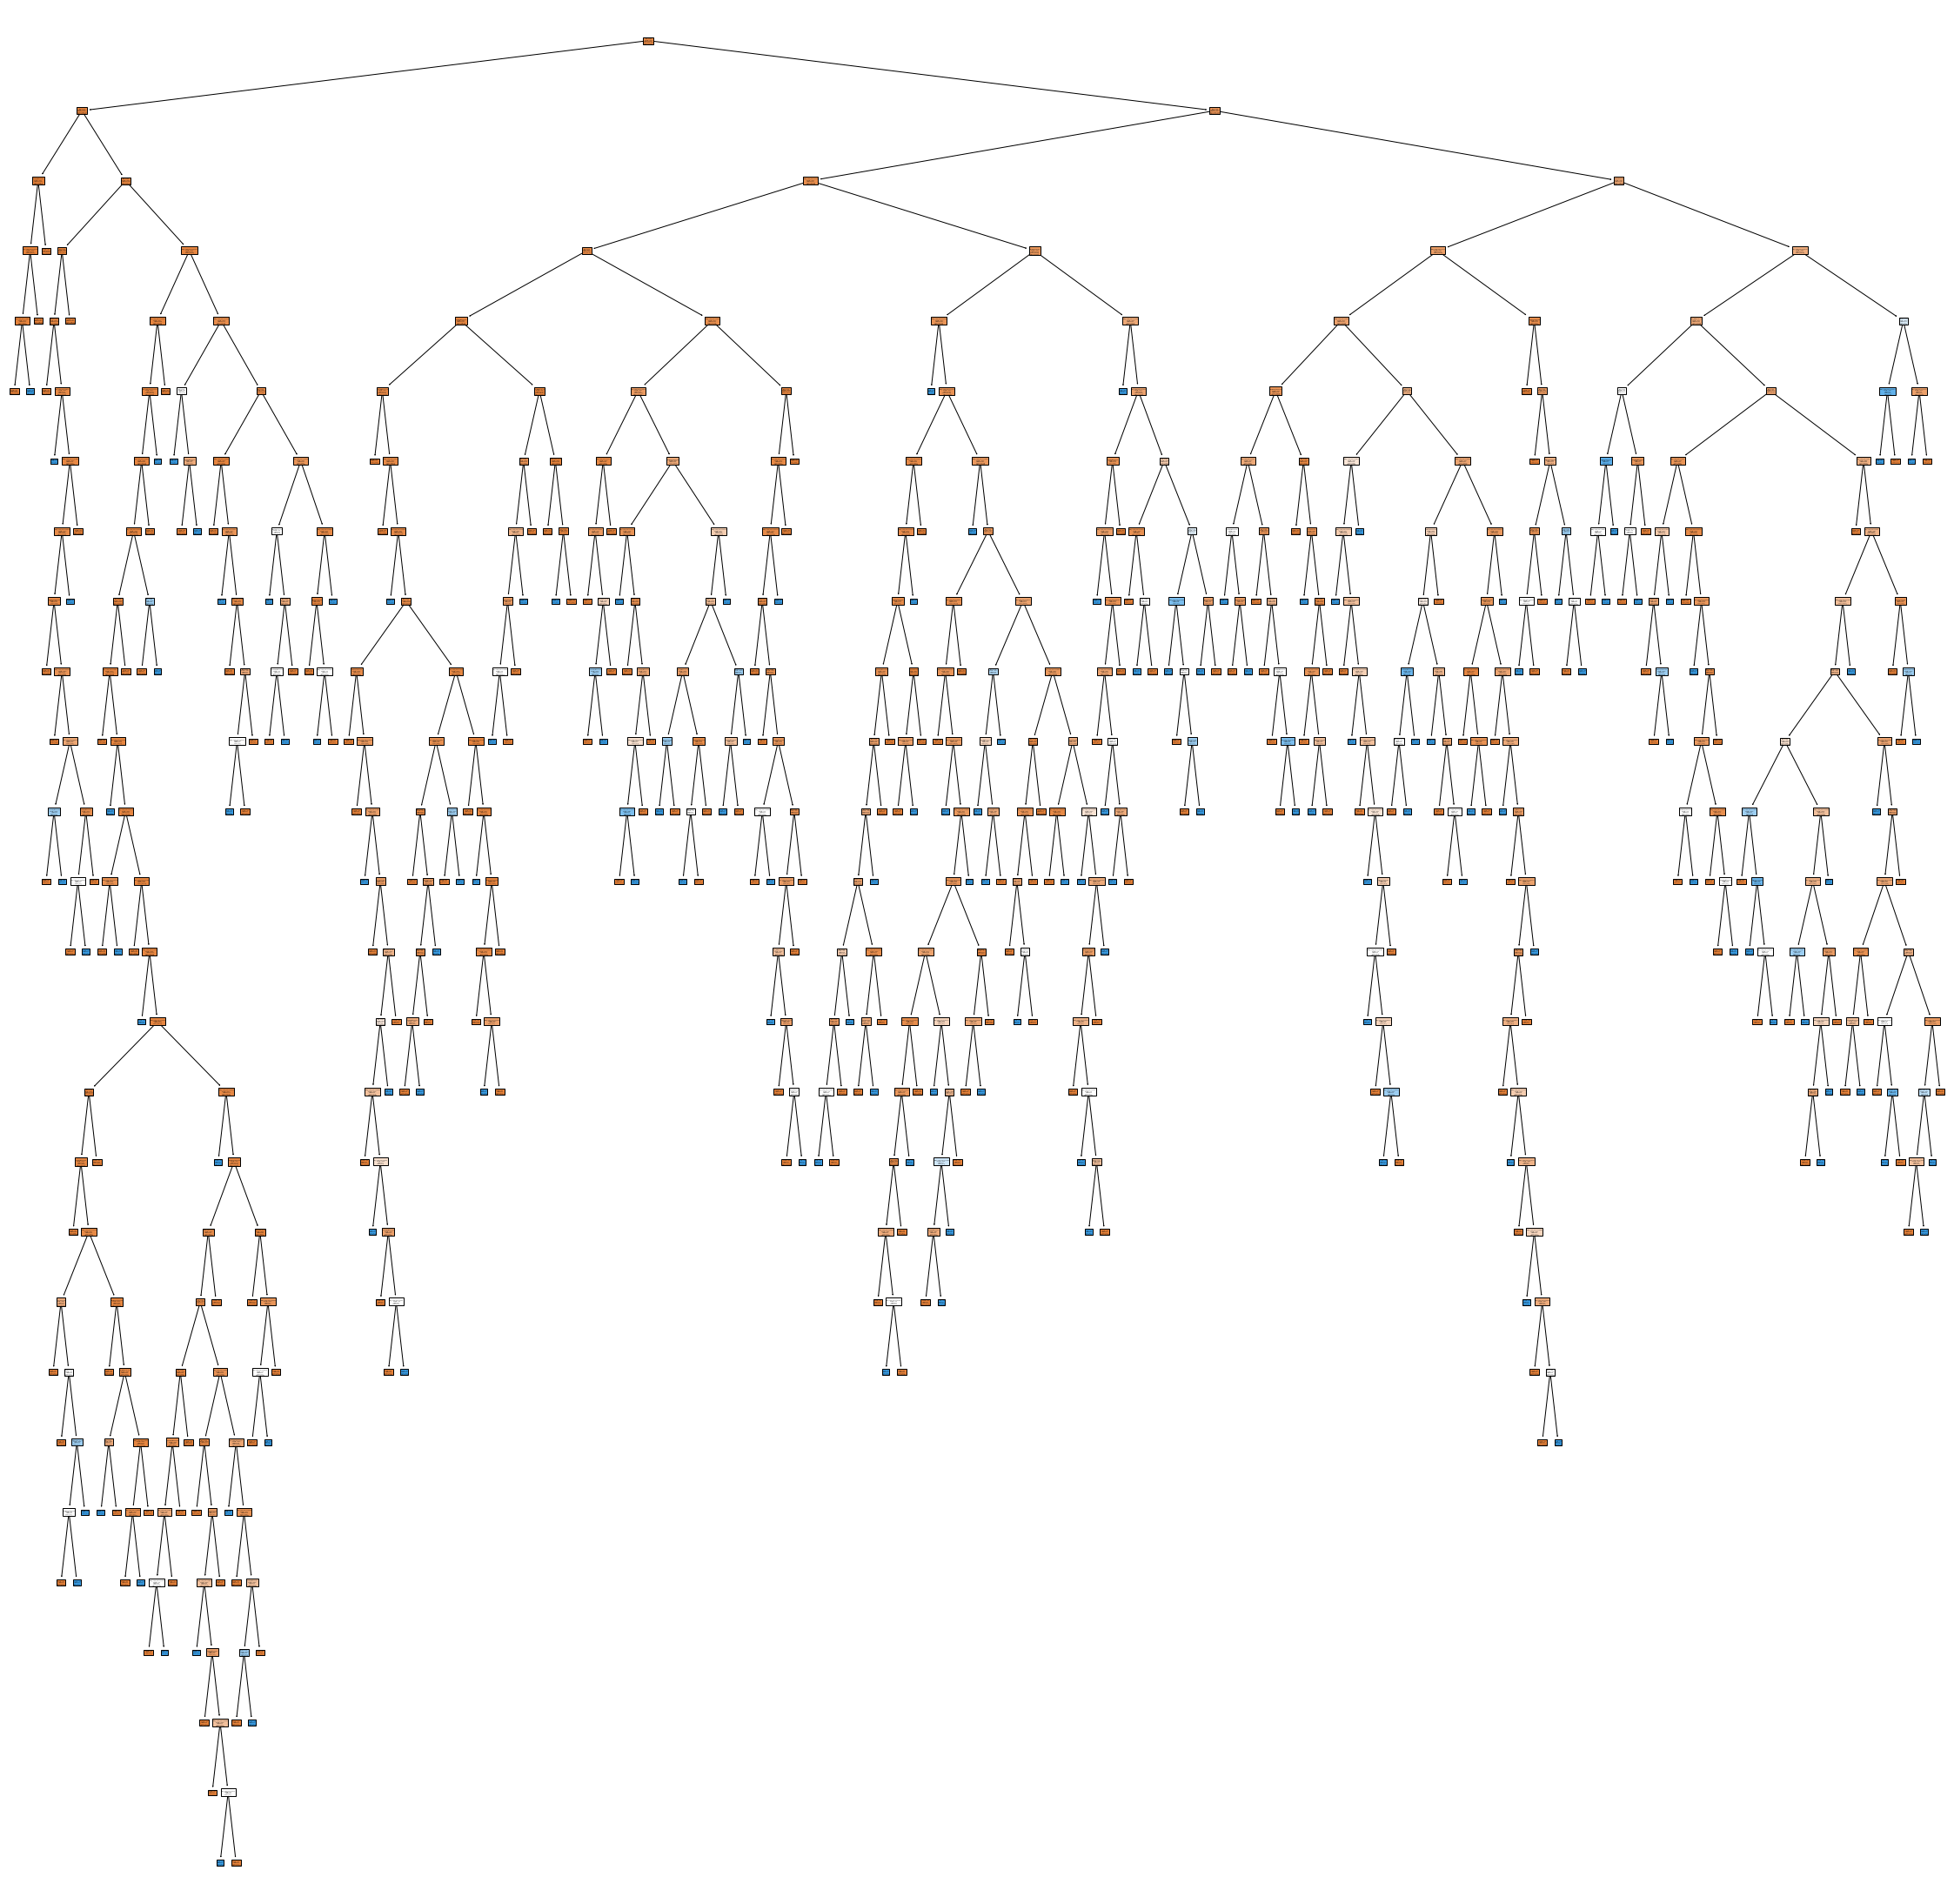

In [ ]:
fig = plt.figure(figsize=(40,40))
_ = plot_tree(clf, 
             feature_names=columns,  
             class_names=['no stroke', 'stroke'],
             filled=True)
plt.show()

#### Conclusion
This classifier is not workin all to well. TODO explain

The recall score of the naive bayes classifier is 0.603076219512195


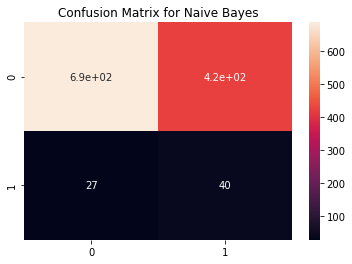

In [ ]:
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
from itertools import product

model = ComplementNB()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=40)
scores = cross_val_score(model, X_n, y, scoring='recall', cv=cv, n_jobs=4)
print('The recall score of the naive bayes classifier is {}'.format(np.mean(scores)))


# make a test with confusion matrix
X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size=0.33, stratify=y)
model.fit(X_train, y_train)
cm = confusion_matrix(y_test, model.predict(X_test))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

#### Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

kernels = ['poly', 'rbf', 'sigmoid']
degrees = [x for x in range(7, 14)]
hypers = [(x, y) for x in kernels for y in degrees if x == 'poly' or y == 3]
print(hypers)

avg_scores = []

for kernel, degree in hypers:
    if kernel=='poly':
        model = SVC(kernel=kernel, degree=degree)
    scores = cross_val_score(model, X_n, y, scoring='recall', n_jobs=7)
    print('The svm with kernel "{}" has recall {}'.format(kernel, np.mean(scores)))

[('poly', 0), ('poly', 1), ('poly', 2), ('poly', 3), ('poly', 4), ('poly', 5), ('poly', 6), ('poly', 7), ('poly', 8), ('poly', 9), ('rbf', 3), ('sigmoid', 3)]
The svm with kernel "poly" has recall 0.0
The svm with kernel "poly" has recall 0.0
The svm with kernel "poly" has recall 0.0
The svm with kernel "poly" has recall 0.0
The svm with kernel "poly" has recall 0.0
The svm with kernel "poly" has recall 0.0
